In [1]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax
from theano import function
from scipy.misc import imread
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import os
import pickle
import lasagne
from data_preprocessing import get_cities, prepare_dataset, ReadFilePaths, proportional_resize
import itertools
%matplotlib inline

def build_model(input_shape):
    net = {}
    
    net['input'] = InputLayer((None, input_shape[2], input_shape[0], input_shape[1]))
    
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    
    
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Using gpu device 0: GeForce GTX 765M (CNMeM is disabled, cuDNN 5004)


In [2]:
with open('vgg19.pkl', 'rb') as f:
    params = pickle.load(f)

In [3]:
images_path = '/home/aelphy/Downloads/leftImg8bit/'

first_img_path = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(images_path)) for f in fn][0]
img = imread(first_img_path)
first_img = proportional_resize(img)
net = build_model(first_img.shape)

In [4]:
last_vgg_layer = net['pool5']
lasagne.layers.set_all_param_values(last_vgg_layer, params['param values'][:32])

In [5]:
input_X = T.tensor4('X')

output = lasagne.layers.get_output(last_vgg_layer, input_X, deterministic = True)
features = function([input_X], output)

In [22]:
MEAN_VALUES = np.array([104, 117, 123], dtype=np.float32).reshape(1, 3, 1, 1)
 
def preprocess(img):
    return np.rollaxis(img, 2)[::-1][None] - MEAN_VALUES

def deprocess(img):
    return np.transpose((img + MEAN_VALUES)[0, ::-1], (1, 2, 0))

In [48]:
def featurize(X):
    data = [None] * len(X)

    for i, img in enumerate(X):
        img = proportional_resize(img)
        data[i] = features(preprocess(img)).ravel()

    return data

### Data loading

In [8]:
def load_data(modes):
    cities = get_cities()
    dataset = prepare_dataset(
            itertools.chain(*[zip(ReadFilePaths(mode, city, 'leftImg8bit'),
                                  ReadFilePaths(mode, city, 'gtFine', 'gtFine_color.png'),
                                  ReadFilePaths(mode, city, 'disparity'))
                            for mode in modes for city in cities[mode]]))
    return zip(*dataset)

In [3]:
%%time
X_val, y_val = load_data(['val'])

CPU times: user 1min 43s, sys: 3.1 s, total: 1min 46s
Wall time: 2min 11s


In [4]:
%%time
X_train, y_train = load_data(['train'])

CPU times: user 10min 16s, sys: 21.2 s, total: 10min 37s
Wall time: 13min 5s


In [5]:
%%time
X_test, y_test = load_data(['test'])

CPU times: user 5min 3s, sys: 23.6 s, total: 5min 27s
Wall time: 6min 40s


In [26]:
X_val = np.array(X_val)
y_val = np.array(y_val)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [39]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

In [9]:
import pickle

with open('data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

In [52]:
%%time
f_val = featurize(X_val)
f_train = featurize(X_train)
f_test = featurize(X_test)

CPU times: user 8min 13s, sys: 1min 51s, total: 10min 4s
Wall time: 10min 4s


In [54]:
len(f_train), f_train[0].shape

(2975, (18432,))

In [53]:
with open('features.pkl', 'wb') as f:
    pickle.dump((f_train, y_train, f_val, y_val, f_test, y_test), f)

In [ ]:
with open('features.pkl', 'rb') as f:
    f_train, y_train, f_val, y_val, f_test, y_test = pickle.dump(f)

(array([  16.,   49.,   88.,  163.,  109.,  125.,  120.,  113.,  127.,
         106.,  132.,  134.,  115.,  195.,  295.,  368.,  252.,  131.,
         125.,  212.]),
 array([  14. ,   19.6,   25.2,   30.8,   36.4,   42. ,   47.6,   53.2,
          58.8,   64.4,   70. ,   75.6,   81.2,   86.8,   92.4,   98. ,
         103.6,  109.2,  114.8,  120.4,  126. ]),
 <a list of 20 Patch objects>)

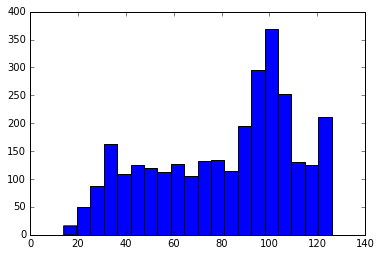

In [55]:
plt.hist(y_train, bins=20)

In [74]:
y_train

126

In [82]:
bins = [np.percentile(y_train, 0),
       np.percentile(y_train, 50),
       np.percentile(y_train, 100) + 1]

In [85]:
bins

[14.0, 89.0, 127.0]

In [83]:
y_train = np.digitize(y_train, bins)
y_val = np.digitize(y_val, bins)
y_test = np.digitize(y_test, bins)

(array([ 1454.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1521.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

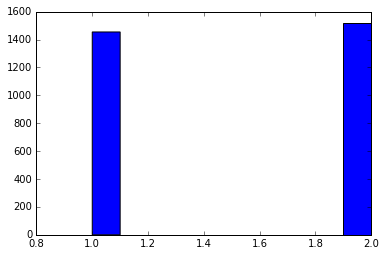

In [84]:
plt.hist(y_train)

In [101]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(f_train, y_train).score(f_val, y_val)

0.73199999999999998